In [1]:
# %% imports
import scipy
import scipy.io
import scipy.stats

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from tqdm import tqdm

from eskf import (
    ESKF,
    POS_IDX,
    VEL_IDX,
    ATT_IDX,
    ACC_BIAS_IDX,
    GYRO_BIAS_IDX,
    ERR_ATT_IDX,
    ERR_ACC_BIAS_IDX,
    ERR_GYRO_BIAS_IDX,
)

from quaternion import quaternion_to_euler
from cat_slice import CatSlice


# to see your plot config
print(f"matplotlib backend: {matplotlib.get_backend()}")
print(f"matplotlib config file: {matplotlib.matplotlib_fname()}")
print(f"matplotlib config dir: {matplotlib.get_configdir()}")
plt.close("all")

# set styles
try:
    plt_styles = ["science", "grid", "bright", "no-latex"]
    plt.style.use(plt_styles)
    print(f"pyplot using style set {plt_styles}")
except Exception as e:
    print(e)
    print("setting grid and only grid and legend manually")
    plt.rcParams.update(
        {
            # setgrid
            "axes.grid": True,
            "grid.linestyle": ":",
            "grid.color": "k",
            "grid.alpha": 0.5,
            "grid.linewidth": 0.5,
            # Legend
            "legend.frameon": True,
            "legend.framealpha": 1.0,
            "legend.fancybox": True,
            "legend.numpoints": 1,
        }
    )

# %% load data and plot
filename_to_load = "task_real.mat"
loaded_data = scipy.io.loadmat(filename_to_load)

do_corrections = False # TODO: set to false for the last task
if do_corrections:
    S_a = loaded_data['S_a']
    S_g = loaded_data['S_g']
else:
    # Only accounts for basic mounting directions
    S_a = S_g = np.array([[0, 1, 0], [-1, 0, 0], [0, 0, 1]])

lever_arm      = loaded_data["leverarm"].ravel()
timeGNSS       = loaded_data["timeGNSS"].ravel()
timeIMU        = loaded_data["timeIMU"].ravel()
z_acceleration = loaded_data["zAcc"].T
z_GNSS         = loaded_data["zGNSS"].T
z_gyroscope    = loaded_data["zGyro"].T
accuracy_GNSS  = loaded_data['GNSSaccuracy'].ravel()
imu0, gnss0    = 0, 0

SKIP = 1
N_stop = 100000


if SKIP: #skips stationary part 
    imu0  = 50000
    gnss0 = 200
    
timeIMU        = timeIMU[imu0:]
timeGNSS       = timeGNSS[gnss0:]
z_acceleration = z_acceleration[imu0:]
z_gyroscope    = z_gyroscope[imu0:]
z_GNSS         = z_GNSS[gnss0:]

dt         = np.mean(np.diff(timeIMU))
steps      = len(z_acceleration)
gnss_steps = len(z_GNSS)

print("Steps: ", steps, " | GNSS steps: ", gnss_steps, "| dt:", dt)

matplotlib backend: module://ipykernel.pylab.backend_inline
matplotlib config file: /home/jakobeg/.local/lib/python3.6/site-packages/matplotlib/mpl-data/matplotlibrc
matplotlib config dir: /home/jakobeg/.config/matplotlib
pyplot using style set ['science', 'grid', 'bright', 'no-latex']
Steps:  870535  | GNSS steps:  3483 | dt: 0.004000064186912818


In [2]:
# %% Measurement noise

# Continous noise
cont_acc_noise_std   = 5e-2#6e-3 #1.17e-3     # (m/s²) / sqrt(Hz)
cont_gyro_noise_std  = 4e-4#1e-4 #4.36e-5     # (rad/s) / sqrt(Hz)

# Discrete sample noise at simulation rate used
dt_imu   = 0.004
acc_std  = cont_acc_noise_std*np.sqrt(1/dt_imu)  #1/dt_imu)
rate_std = cont_gyro_noise_std*np.sqrt(1/dt_imu)  #1/dt_imu)

# Bias values
acc_bias_driving_noise_std       = 4e-4   # 4e-3 # discrete
rate_bias_driving_noise_std      = 4e-5 # 5e-5 # discrete 
cont_acc_bias_driving_noise_std  = acc_bias_driving_noise_std/np.sqrt(1/dt_imu)
cont_rate_bias_driving_noise_std = rate_bias_driving_noise_std/np.sqrt(1/dt_imu)

# Position and velocity measurement
p_acc  = 1e-8
p_gyro = 1e-8

# %% Estimator
eskf = ESKF(
    acc_std,                              # -> sigma_acc       = 
    rate_std,                             # -> sigma_gyro      = 
    cont_acc_bias_driving_noise_std,      # -> sigma_acc_bias  = 
    cont_rate_bias_driving_noise_std,     # -> sigma_gyro_bias = 
    p_acc,                                # -> p_acc           = 
    p_gyro,                               # -> p_gyro          = 
    S_a = S_a, # set the accelerometer correction matrix
    S_g = S_g, # set the gyro correction matrix,
    debug=False # False to avoid expensive debug checks
)


# %% Allocate
x_est  = np.zeros((steps, 16))
P_est  = np.zeros((steps, 15, 15))

x_pred = np.zeros((steps, 16))
P_pred = np.zeros((steps, 15, 15))



# %% Initialise
x_pred[0, POS_IDX] = z_GNSS[0].copy() # np.array([0, 0, 0])
x_pred[0, VEL_IDX] = np.array([0, 0, 0]) 
x_pred[0, ATT_IDX] = np.array([
    np.cos(45 * np.pi / 180),
    0, 0,
    np.sin(45 * np.pi / 180)
])  # nose to east and belly down.

#Initialize covariances
P_pred[0][POS_IDX **2]           =  3**2 * np.eye(3) #10**2 * np.eye(3)
P_pred[0][VEL_IDX **2]           =  3**2 * np.eye(3) # 3**2 * np.eye(3)
P_pred[0][ERR_ATT_IDX **2]       = (7*np.pi/180)**2 * np.eye(3)  #(np.pi/30)**2 * np.eye(3) 
P_pred[0][ERR_ACC_BIAS_IDX **2]  = (3*acc_std)**2 * np.eye(3) 
P_pred[0][ERR_GYRO_BIAS_IDX **2] = (4*rate_std)**2 * np.eye(3)


# %% Run estimation
N  = N_stop-imu0 #steps

NIS_steps    = int(N*gnss_steps/steps)
NIS          = np.zeros(NIS_steps)
NIS_planar   = np.zeros(NIS_steps)
NIS_altitude = np.zeros(NIS_steps)

GNSSk  = 0
for k in tqdm(range(0, N)):
    if timeIMU[k] >= timeGNSS[GNSSk]:
        
        #: Current GNSS covariance
        R_GNSS = np.diag([(0.3**2*accuracy_GNSS[GNSSk]), 
                          (0.3**2*accuracy_GNSS[GNSSk]), 
                          (0.2**2*accuracy_GNSS[GNSSk])])
        
        x_est[k], P_est[k]  = eskf.update_GNSS_position(x_pred[k], P_pred[k], z_GNSS[GNSSk], R_GNSS, lever_arm)
        
        (
            NIS[GNSSk], 
            NIS_planar[GNSSk], 
            NIS_altitude[GNSSk]
        ) = eskf.NIS_GNSS_position(x_pred[k], P_pred[k], z_GNSS[GNSSk], R_GNSS, lever_arm)
        
        if eskf.debug:
            assert np.all(np.isfinite(P_est[k])), f"Not finite P_pred at index {k}"
        GNSSk += 1
        
    else:
        x_est[k] = x_pred[k]
        P_est[k] = P_pred[k]

    if k < N - 1:
        x_pred[k+1], P_pred[k+1] = eskf.predict(x_est[k], P_est[k], z_acceleration[k+1], z_gyroscope[k+1], dt)

    if eskf.debug:
        assert np.all(np.isfinite(P_pred[k])), f"Not finite P_pred at index {k + 1}"
print(f"N \t = {N} (of {steps}) \nGNSSk \t = {GNSSk} (of {gnss_steps})")

100%|██████████| 50000/50000 [01:02<00:00, 799.89it/s]

N 	 = 50000 (of 870535) 
GNSSk 	 = 200 (of 3483)


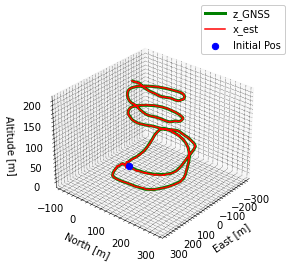

In [6]:

# %% Plots

fig1 = plt.figure(1, figsize=(4,4))
ax = plt.axes(projection='3d')


ax.plot3D(z_GNSS[:GNSSk, 1], z_GNSS[:GNSSk, 0], -z_GNSS[:GNSSk, 2], linewidth=3,  c='green',label="z_GNSS")
ax.plot3D(x_est[:N, 1], x_est[:N, 0], -x_est[:N, 2], linewidth=1.5, c='red', label="x_est")
#ax.plot3D(z_GNSS[:, 1], z_GNSS[:, 0], -z_GNSS[:, 2], linewidth=2, label="z_GNSS full")
ax.scatter(x_est[0, 1], x_est[0, 0], -x_est[0, 2], s=40, c='blue', label="Initial Pos")
ax.set_xlabel("East [m]")
ax.set_ylabel("North [m]")
ax.set_zlabel("Altitude [m]")
fig1.legend()
ax.view_init(30, 40)
fig1.savefig("real_trajectory.pdf",format="pdf")
plt.grid()

ANIS 		= 4.09  with CI = [2.67, 3.35]
ANIS_planar 	= 3.36  with CI = [1.73, 2.29]
ANIS_altitude 	= 0.75  with CI = [0.81, 1.21]


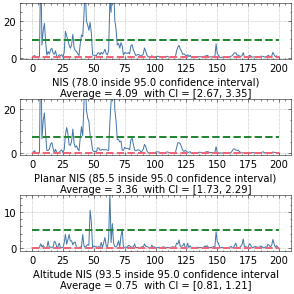

In [4]:
# %% Consistency
confprob = 0.95
CI3 = np.array(scipy.stats.chi2.interval(confprob, 3)).reshape((2, 1))
CI2 = np.array(scipy.stats.chi2.interval(confprob, 2)).reshape((2, 1))
CI  = np.array(scipy.stats.chi2.interval(confprob, 1)).reshape((2, 1))

insideCI3 = np.mean((CI3[0] <= NIS)          * (NIS          <= CI3[1])) #total
insideCI2 = np.mean((CI2[0] <= NIS_planar)   * (NIS_planar   <= CI2[1])) #planar
insideCI  = np.mean((CI[0]  <= NIS_altitude) * (NIS_altitude <= CI[1])) #altitude

#Average NIS
ANIS          = np.mean(NIS[:GNSSk])
ANIS_planar   = np.mean(NIS_planar[:GNSSk])
ANIS_altitude = np.mean(NIS_altitude[:GNSSk])

CI3_A = np.array(scipy.stats.chi2.interval(confprob, 3*GNSSk)).reshape((2, 1)) / GNSSk
CI2_A = np.array(scipy.stats.chi2.interval(confprob, 2*GNSSk)).reshape((2, 1)) / GNSSk
CI_A  = np.array(scipy.stats.chi2.interval(confprob, 1*GNSSk)).reshape((2, 1)) / GNSSk


fig3, axs3 = plt.subplots(3, 1, figsize=(4,4))

axs3[0].plot(NIS[:GNSSk])
axs3[0].plot(np.array([0, N-1]) * dt, (CI3@np.ones((1, 2))).T, linestyle='--',linewidth=2)
axs3[0].set_xlabel(f'NIS ({100 *  insideCI3:.1f} inside {100 * confprob} confidence interval)\nAverage = {ANIS:.2f}  with CI = [{CI3_A[0][0]:.2f}, {CI3_A[1][0]:.2f}]')
axs3[0].set_ylim(-1, 30)

axs3[1].plot(NIS_planar[:GNSSk])
axs3[1].plot(np.array([0, N-1]) * dt, (CI2@np.ones((1, 2))).T, linestyle='--',linewidth=2)
axs3[1].set_xlabel(f'Planar NIS ({100 *  insideCI2:.1f} inside {100 * confprob} confidence interval)\nAverage = {ANIS_planar:.2f}  with CI = [{CI2_A[0][0]:.2f}, {CI2_A[1][0]:.2f}]')
axs3[1].set_ylim(-1, 25)

axs3[2].plot(NIS_altitude[:GNSSk])
axs3[2].plot(np.array([0, N-1]) * dt, (CI@np.ones((1, 2))).T, linestyle='--',linewidth=2)
axs3[2].set_xlabel(f'Altitude NIS ({100 *  insideCI:.1f} inside {100 * confprob} confidence interval\nAverage = {ANIS_altitude:.2f}  with CI = [{CI_A[0][0]:.2f}, {CI_A[1][0]:.2f}]')
axs3[2].set_ylim(-1, 15)

fig3.tight_layout(pad=0.01)
fig3.savefig("NIS_real.pdf",format="pdf")

print(f"ANIS \t\t= {ANIS:.2f}  with CI = [{CI3_A[0][0]:.2f}, {CI3_A[1][0]:.2f}]")
print(f"ANIS_planar \t= {ANIS_planar:.2f}  with CI = [{CI2_A[0][0]:.2f}, {CI2_A[1][0]:.2f}]")
print(f"ANIS_altitude \t= {ANIS_altitude:.2f}  with CI = [{CI_A[0][0]:.2f}, {CI_A[1][0]:.2f}]")

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


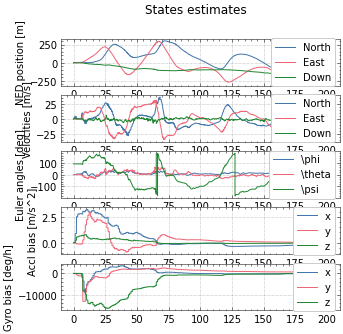

In [5]:
# state estimation
t = np.linspace(0, dt*(N-1), N)
eul = np.apply_along_axis(quaternion_to_euler, 1, x_est[:N, ATT_IDX])

fig2, axs2 = plt.subplots(5, 1, figsize=(5,5))

axs2[0].plot(t, x_est[0:N, POS_IDX])
axs2[0].set(ylabel='NED position [m]')
axs2[0].legend(['North', 'East', 'Down'], loc=5)

axs2[1].plot(t, x_est[0:N, VEL_IDX])
axs2[1].set(ylabel='Velocities [m/s]')
axs2[1].legend(['North', 'East', 'Down'], loc=5)

axs2[2].plot(t, eul[0:N] * 180 / np.pi)
axs2[2].set(ylabel='Euler angles [deg]')
axs2[2].legend(['\phi', '\\theta', '\psi'], loc=5)

axs2[3].plot(t, x_est[0:N, ACC_BIAS_IDX])
axs2[3].set(ylabel='Accl bias [m/s^2]')
axs2[3].legend(['x', 'y', 'z'], loc=5)

axs2[4].plot(t, x_est[0:N, GYRO_BIAS_IDX] * 180 / np.pi * 3600)
axs2[4].set(ylabel='Gyro bias [deg/h]')
axs2[4].legend(['x', 'y', 'z'], loc=5)
plt.grid(1)

fig2.suptitle('States estimates')
fig2.savefig("States2_False.pdf",format="pdf")